In [1]:
import json
import jsonschema
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as dates
import os

In [20]:
files = os.scandir("data/deaths_hu")
file_names = []
for file in files:
    if file.name != "latest.json" and file.name[-5:] == ".json":
        file_names.append(file.name)
        if file.name[0:10]=="2020-09-26" or file.name[0:10]=="2020-09-27":
            print(file.name)
file_names.sort()

2020-09-26 07:09:10.676058.json
2020-09-26 08:09:37.569513.json
2020-09-27 07:40:33.677169.json


In [21]:
def json2df(filename):
    df = pd.read_json("data/deaths_hu/{}".format(filename)).dropna()
    df["Sorszám"] = df["Sorszám"].astype(int)
    df["Kor"].replace('', None, inplace=True)
    df["Kor"] = df["Kor"].astype(int)
    df["date"] = pd.to_datetime(filename[0:10], format='%Y-%m-%d')
    return df.set_index(["Sorszám", "Nem", "Kor"])

def join(df1, df2):
    df3 = df1.join(df2, lsuffix="_left", rsuffix="_right", how='outer')
    df3["date"] = df3.apply(lambda row: find_first_val(row, "date", "date"), axis=1)
    df3["Alapbetegségek"] = df3.apply(lambda row: find_first_val(row, "date", "Alapbetegségek"), axis=1)
    # df3[df3["Alapbetegségek_left"]!=df3["Alapbetegségek_right"]]
    return df3[["date", "Alapbetegségek"]]

def find_first_val(row, date_col, val_col):
    if pd.isnull(row["{}_left".format(date_col)]):
        return row["{}_right".format(val_col)]
    else:
        return row["{}_left".format(val_col)]

In [22]:
df0 = json2df(file_names[0])
for key in range(1, len(file_names)):
    df1 = json2df(file_names[key])
    df0 = join(df0, df1)

In [23]:
df = df0.reset_index()
df[df["Kor"]<60].tail(10)

,Sorszám,Nem,Kor,date,Alapbetegségek
4458,4425,férfi,56,2020-11-28,heveny hasnyálmirigy gyulladás
4459,4426,nõ,56,2020-11-28,"tüdõbetegség, daganatos betegség"
4486,4453,nõ,55,2020-11-28,daganatos betegség
4489,4456,nõ,53,2020-11-28,"daganatos betegség, cukorbetegség"
4493,4460,férfi,59,2020-11-28,"magas vérnyomás, cukorbetegség"
4510,4477,nõ,57,2020-11-28,"Szklerózis multiplex, trombózis"
4523,4490,nõ,57,2020-11-28,nem ismert alapbetegség
4527,4494,férfi,57,2020-11-28,"szívelégtelenség, daganatos betegség, magas vé..."
4531,4498,nõ,51,2020-11-28,daganatos betegségek
4539,4506,férfi,45,2020-11-28,daganatos megbetegedés


In [24]:
df["Kor_class"] = df["Kor"].apply(lambda cell: cell - (cell % 10))
df["week"] = df["date"].dt.week + df["date"].dt.year * 100
df["day"] = df["date"] - pd.to_timedelta(df['date'].dt.dayofweek, unit="D")
df_group = df.groupby(["day", "Kor_class"]).agg({"Nem":"count"}).reset_index()

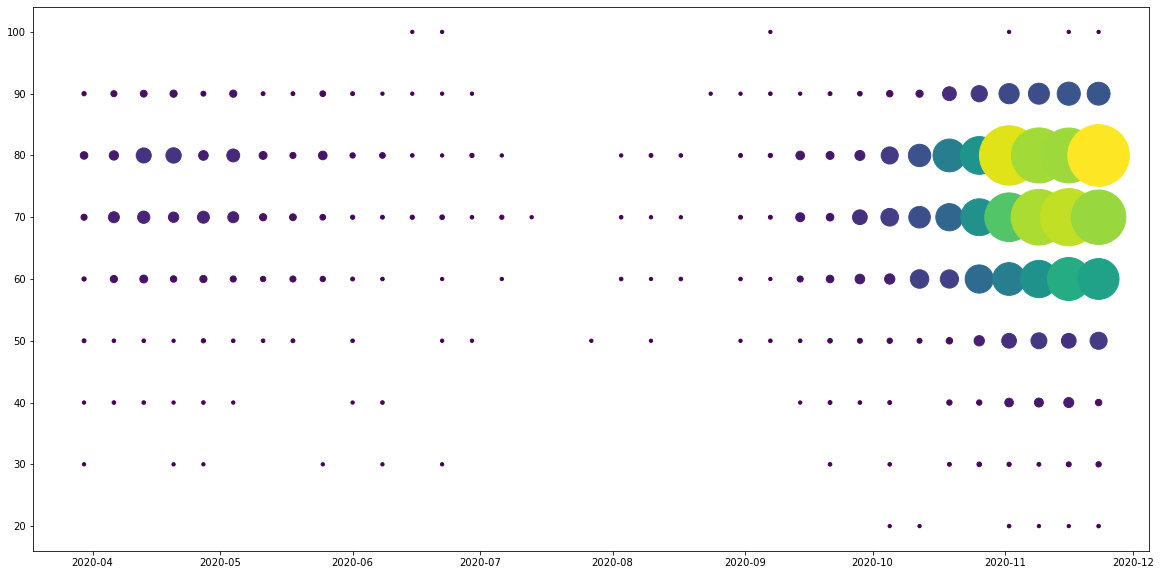

In [25]:
plt.subplots(figsize=(20,10))
plt.scatter(x=df_group["day"], y=df_group["Kor_class"], s=10+df_group["Nem"]**1.5, c=df_group["Nem"])
plt.show()